## Когортный анализ

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

### Некоторые настройки

In [2]:
pd.set_option('max_columns', 50)
mpl.rcParams['lines.linewidth'] = 2

In [3]:
%matplotlib inline

### Загрузка данных

In [4]:
df = pd.read_csv('../data/relay-foods.csv')

In [5]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'], dayfirst=True)
df['TotalCharges'] = df['TotalCharges'].astype(float)
df['PickupDate'] = pd.to_datetime(df['PickupDate'], dayfirst=True)

In [6]:
df.dtypes

OrderId                  int64
OrderDate       datetime64[ns]
UserId                   int64
TotalCharges           float64
CommonId                object
PupId                    int64
PickupDate      datetime64[ns]
dtype: object

### Посмотрим на данные

In [7]:
df.head()

OrderId  OrderDate  UserId  TotalCharges CommonId  PupId PickupDate
0      262 2009-01-11      47         50.67    TRQKD      2 2009-01-12
1      278 2009-01-20      47         26.60    4HH2S      3 2009-01-20
2      294 2009-02-03      47         38.71    3TRDC      2 2009-02-04
3      301 2009-02-06      47         53.38    NGAZJ      2 2009-02-09
4      302 2009-02-06      47         14.28    FFYHD      2 2009-02-09

### Создадим столбец на основе даты заказа (дата заказа 01.12.2009 -> период заказа 12.2009)

In [8]:
df['OrderPeriod'] = df.OrderDate.apply(lambda x: x.strftime('%Y-%m'))

In [9]:
df.head()

OrderId  OrderDate  UserId  TotalCharges CommonId  PupId PickupDate  \
0      262 2009-01-11      47         50.67    TRQKD      2 2009-01-12   
1      278 2009-01-20      47         26.60    4HH2S      3 2009-01-20   
2      294 2009-02-03      47         38.71    3TRDC      2 2009-02-04   
3      301 2009-02-06      47         53.38    NGAZJ      2 2009-02-09   
4      302 2009-02-06      47         14.28    FFYHD      2 2009-02-09   

  OrderPeriod  
0     2009-01  
1     2009-01  
2     2009-02  
3     2009-02  
4     2009-02

### Создадим столбец с когортами, на основе даты первого заказа (дата первого заказа 01.02.2009 -> когорта 02.2009)

In [10]:
df.set_index('UserId', inplace=True)
df['CohortGroup'] = df.groupby(level=0)['OrderDate'].min().apply(lambda x: x.strftime('%Y-%m'))
df.reset_index(inplace=True)

In [11]:
df.head()

UserId  OrderId  OrderDate  TotalCharges CommonId  PupId PickupDate  \
0      47      262 2009-01-11         50.67    TRQKD      2 2009-01-12   
1      47      278 2009-01-20         26.60    4HH2S      3 2009-01-20   
2      47      294 2009-02-03         38.71    3TRDC      2 2009-02-04   
3      47      301 2009-02-06         53.38    NGAZJ      2 2009-02-09   
4      47      302 2009-02-06         14.28    FFYHD      2 2009-02-09   

  OrderPeriod CohortGroup  
0     2009-01     2009-01  
1     2009-01     2009-01  
2     2009-02     2009-01  
3     2009-02     2009-01  
4     2009-02     2009-01

### Сгруппируем данные по когортам и периодам заказа

In [12]:
grouped = df.groupby(['CohortGroup', 'OrderPeriod'])

# Количество уникальных пользователей, заказов и общей выручки на группу
cohorts = grouped.agg({'UserId': pd.Series.nunique,
                       'OrderId': pd.Series.nunique,
                       'TotalCharges': np.sum})

# Переименуем столбцы
cohorts.rename(columns={'UserId': 'TotalUsers',
                        'OrderId': 'TotalOrders'}, inplace=True)

In [13]:
cohorts.head()

TotalUsers  TotalOrders  TotalCharges
CohortGroup OrderPeriod                                       
2009-01     2009-01              22           30       1850.26
            2009-02               8           25       1351.07
            2009-03              10           26       1357.36
            2009-04               9           28       1604.50
            2009-05              10           26       1575.63

### Посчитаем период для каждой когорты, которая базируется на дате первого заказа

In [14]:
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)

In [15]:
cohorts.head()

TotalUsers  TotalOrders  TotalCharges  CohortPeriod
CohortGroup OrderPeriod                                                     
2009-01     2009-01              22           30       1850.26             1
            2009-02               8           25       1351.07             2
            2009-03              10           26       1357.36             3
            2009-04               9           28       1604.50             4
            2009-05              10           26       1575.63             5

### Посчитаем User Retention

In [16]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()

In [17]:
cohort_group_size.head()

CohortGroup
2009-01    22
2009-02    15
2009-03    13
2009-04    39
2009-05    50
Name: TotalUsers, dtype: int64

In [18]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)

### Визуализируем когорты

(15.0, 0.0)

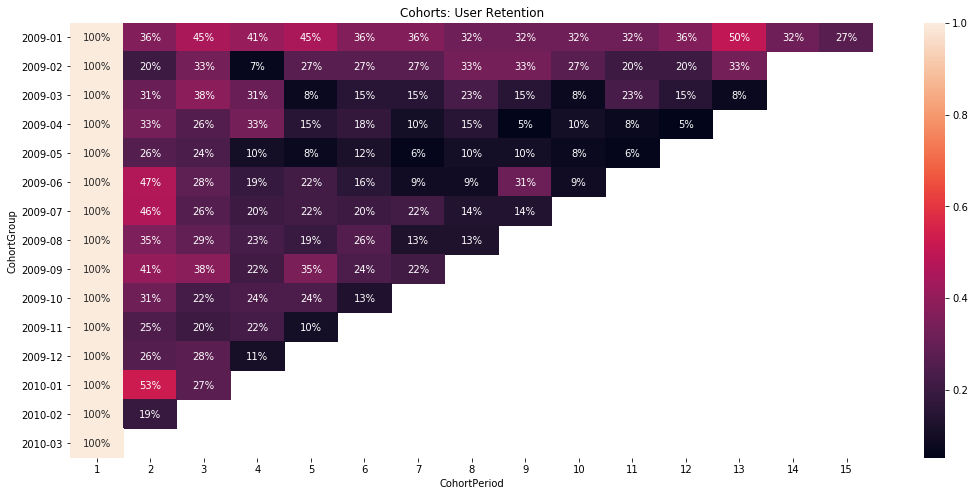

In [19]:
plt.figure(figsize=(18, 8))
plt.title('Cohorts: User Retention')
ax = sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)